Setup & imports

In this section we import all required libraries and initialize the OpenAI client.

In [1]:
import os
from openai import OpenAI

def get_openai_client():
    key = os.environ.get("OPENAI_API_KEY")
    
    if not key:
        key = input("Enter your OpenAI API key: ").strip()
        os.environ["OPENAI_API_KEY"] = key

    return OpenAI(api_key=key)

client = get_openai_client()
print("OpenAI client is ready.")


if "OPENAI_API_KEY" not in os.environ or not os.environ["OPENAI_API_KEY"]:
   os.environ["OPENAI_API_KEY"] = input("OPENAI-API-KEY")
print("API key OK.")
print(os.environ.get("OPENAI_API_KEY") is not None)




OpenAI client is ready.
API key OK.
True


In [2]:
# IMPORTS AND OPENAI CLIENT

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay

# expects that OPENAI_API_KEY is set in the environment, e.g. via .env or system env
#os.environ["OPENAI_API_KEY"] = "YOUR-API-KEY"
client = OpenAI()

DATA_DIR = Path("..") / "data"
DATA_DIR, list(DATA_DIR.iterdir())

(PosixPath('../data'),
 [PosixPath('../data/.ipynb_checkpoints'),
  PosixPath('../data/data.csv'),
  PosixPath('../data/Untitled.ipynb')])

1. Load & preprocess

We load the dataset, merge headline and body text, clean missing values, and perform a basic exploratory data analysis (EDA).

In [3]:
# LOAD DATA

df = pd.read_csv(DATA_DIR / "data.csv")

df.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [4]:
# PREPROCESS TEXT

df["text"] = df["Headline"].fillna("") + " " + df["Body"].fillna("")
data = df[["text", "Label"]].rename(columns={"Label": "label"})
data = data.dropna(subset=["text", "label"])

data.head()

data["label"].value_counts()

label
0    2137
1    1872
Name: count, dtype: int64

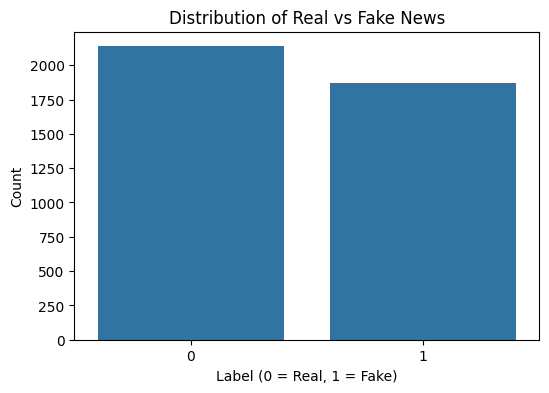

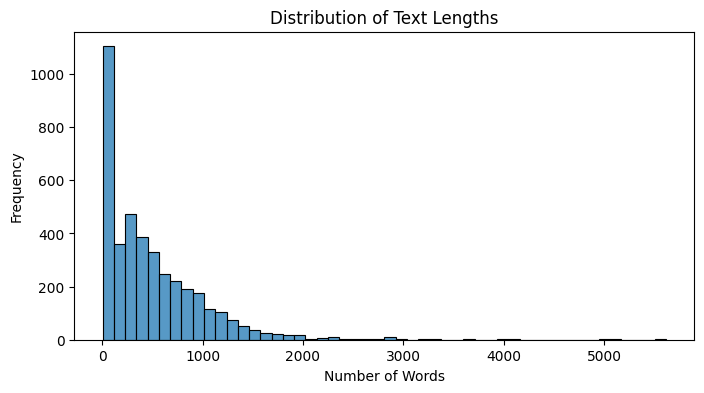

label
0    404.949930
1    600.212073
Name: text_length, dtype: float64

In [5]:
# EDA

plt.figure(figsize=(6,4))
sns.countplot(x="label", data=data)
plt.title("Distribution of Real vs Fake News")
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Count")
plt.show()

data["text_length"] = data["text"].apply(lambda x: len(x.split()))
data["text_length"].describe()

# HISTOGRAM

plt.figure(figsize=(8,4))
sns.histplot(data["text_length"], bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

data.groupby("label")["text_length"].mean()

2. ML baseline
- Train / Test Split
We split the cleaned dataset into training and test sets using stratification to preserve class balance.

- Machine Learning Baseline — TF-IDF + Logistic Regression
We build a traditional ML pipeline consisting of:
 - TF-IDF vectorizer
 - Logistic Regression classifier
This serves as the supervised baseline.

- ML Feature Interpretation — Top Predictive Words

We extract the strongest positive and negative coefficients from the Logistic Regression model to understand which words push predictions toward class 0 (real) or class 1 (fake).


In [6]:
# TRAIN / TEST SPLIT

X = data["text"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((3207,), (802,))

In [7]:
# SAMPLE (80 exampel from the test group)

SAMPLE_SIZE = 80

X_test_sample = X_test[:SAMPLE_SIZE]
y_test_sample = y_test[:SAMPLE_SIZE]

sample_texts = X_test_sample.tolist()
sample_labels = y_test_sample.to_numpy()

len(sample_texts), len(sample_labels)


(80, 80)

In [8]:
# TF-IDF + LOGISTIC REGRESSION PIPELINE

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=50000,
        min_df=2,
        max_df=0.8,
        stop_words="english"
    )),
    ("lr", LogisticRegression(max_iter=200))
])
model.fit(X_train, y_train)

ml_preds = model.predict(X_test)
print("Logistic Regression accuracy:", accuracy_score(y_test, ml_preds))

Logistic Regression accuracy: 0.9750623441396509


In [9]:
# EVALUATION OF ML MODEL

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9750623441396509

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       428
           1       0.96      0.98      0.97       374

    accuracy                           0.98       802
   macro avg       0.97      0.98      0.97       802
weighted avg       0.98      0.98      0.98       802


[[414  14]
 [  6 368]]


In [10]:
# OPENAI CLIENT SETUP
client = OpenAI()  # expects your OPENAI_API_KEY in environment variables

In [11]:
def classify_with_llm(model_name, text):
    """
    Sends a zero-shot classification request to an LLM.
    Expected return: 0 or 1
    """
    prompt = f"""
    Classify the following news article as REAL (0) or FAKE (1).
    Answer with only 0 or 1.

    Article:
    {text}
    """

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=1
        )

        pred = response.choices[0].message["content"].strip()
        return int(pred) if pred in ["0", "1"] else 0

    except Exception as e:
        print("LLM error:", e)
        return 0

def run_llm_on_sample(model_name: str, texts):
    preds = []
    for t in tqdm(texts, desc=f"{model_name} predicting"):
        preds.append(classify_with_llm(model_name, t))
    return np.array(preds, dtype=int)


In [12]:
# Sample of 80 examples from the test set

SAMPLE_SIZE = 80

# use the first 80 examples from X_test / y_test
X_test_sample = X_test[:SAMPLE_SIZE]
y_test_sample = y_test[:SAMPLE_SIZE]

sample_texts = X_test_sample.tolist()
sample_labels = y_test_sample.to_numpy()

len(sample_texts), len(sample_labels)



(80, 80)

In [13]:
llm_preds_mini = []
print("Evaluating GPT-4o-mini...")

for text in tqdm(sample_texts):
    llm_preds_mini.append(classify_with_llm("gpt-4o-mini", text))

print("Accuracy (GPT-4o-mini):", accuracy_score(sample_labels, llm_preds_mini))
print(classification_report(sample_labels, llm_preds_mini))


Evaluating GPT-4o-mini...


  2%|███▏                                                                                                                             | 2/80 [00:02<01:19,  1.02s/it]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


  4%|████▊                                                                                                                            | 3/80 [00:02<00:48,  1.58it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


  5%|██████▍                                                                                                                          | 4/80 [00:02<00:35,  2.16it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


  6%|████████                                                                                                                         | 5/80 [00:02<00:27,  2.69it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


  9%|███████████▎                                                                                                                     | 7/80 [00:03<00:19,  3.67it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 11%|██████████████▌                                                                                                                  | 9/80 [00:03<00:15,  4.48it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 12%|████████████████                                                                                                                | 10/80 [00:03<00:16,  4.32it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 15%|███████████████████▏                                                                                                            | 12/80 [00:04<00:15,  4.51it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 16%|████████████████████▊                                                                                                           | 13/80 [00:04<00:14,  4.62it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 19%|████████████████████████                                                                                                        | 15/80 [00:05<00:13,  4.69it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 21%|███████████████████████████▏                                                                                                    | 17/80 [00:05<00:13,  4.70it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 24%|██████████████████████████████▍                                                                                                 | 19/80 [00:05<00:11,  5.10it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 26%|█████████████████████████████████▌                                                                                              | 21/80 [00:06<00:11,  5.19it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 29%|████████████████████████████████████▊                                                                                           | 23/80 [00:06<00:10,  5.37it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 31%|████████████████████████████████████████                                                                                        | 25/80 [00:06<00:10,  5.49it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 32%|█████████████████████████████████████████▌                                                                                      | 26/80 [00:07<00:09,  5.43it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 34%|███████████████████████████████████████████▏                                                                                    | 27/80 [00:07<00:10,  5.27it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 36%|██████████████████████████████████████████████▍                                                                                 | 29/80 [00:07<00:09,  5.16it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 39%|█████████████████████████████████████████████████▌                                                                              | 31/80 [00:08<00:09,  5.32it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 41%|████████████████████████████████████████████████████▊                                                                           | 33/80 [00:08<00:08,  5.54it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 42%|██████████████████████████████████████████████████████▍                                                                         | 34/80 [00:08<00:07,  5.77it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 45%|█████████████████████████████████████████████████████████▌                                                                      | 36/80 [00:08<00:08,  5.35it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 48%|████████████████████████████████████████████████████████████▊                                                                   | 38/80 [00:09<00:08,  5.23it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 50%|████████████████████████████████████████████████████████████████                                                                | 40/80 [00:09<00:07,  5.26it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 52%|███████████████████████████████████████████████████████████████████▏                                                            | 42/80 [00:10<00:07,  5.14it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 55%|██████████████████████████████████████████████████████████████████████▍                                                         | 44/80 [00:10<00:06,  5.36it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 46/80 [00:10<00:06,  5.21it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 47/80 [00:11<00:06,  5.48it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 49/80 [00:11<00:06,  5.04it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 62%|████████████████████████████████████████████████████████████████████████████████                                                | 50/80 [00:11<00:05,  5.00it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 51/80 [00:11<00:06,  4.79it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 52/80 [00:12<00:05,  4.82it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 54/80 [00:12<00:05,  5.10it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56/80 [00:12<00:04,  5.20it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 57/80 [00:13<00:04,  5.02it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 59/80 [00:13<00:04,  5.13it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61/80 [00:13<00:03,  5.26it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 62/80 [00:14<00:03,  5.25it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64/80 [00:14<00:03,  4.98it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 65/80 [00:14<00:02,  5.32it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 67/80 [00:15<00:02,  5.10it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 68/80 [00:15<00:02,  4.99it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 69/80 [00:15<00:02,  4.97it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 70/80 [00:15<00:02,  4.96it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 72/80 [00:16<00:01,  5.28it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 74/80 [00:16<00:01,  5.37it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 75/80 [00:16<00:00,  5.64it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 77/80 [00:16<00:00,  5.31it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 79/80 [00:17<00:00,  5.49it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.57it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Accuracy (GPT-4o-mini): 0.525
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        42
           1       0.00      0.00      0.00        38

    accuracy                           0.53        80
   macro avg       0.26      0.50      0.34        80
weighted avg       0.28      0.53      0.36        80




/mnt/c/Users/steva/OneDrive/Programiranje/Neural Networks/Projects/fake-real-news-ml-vs-llm/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/steva/OneDrive/Programiranje/Neural Networks/Projects/fake-real-news-ml-vs-llm/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/steva/OneDrive/Programiranje/Neural Networks/Projects/fake-real-news-ml-vs-llm/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision an

In [14]:
llm_preds_4o = []
print("Evaluating GPT-4o (Large)...")

for text in tqdm(sample_texts):
    llm_preds_4o.append(classify_with_llm("gpt-4o", text))

print("Accuracy (GPT-4o):", accuracy_score(sample_labels, llm_preds_4o))
print(classification_report(sample_labels, llm_preds_4o))


Evaluating GPT-4o (Large)...


  1%|█▌                                                                                                                               | 1/80 [00:00<00:12,  6.33it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


  2%|███▏                                                                                                                             | 2/80 [00:00<00:12,  6.30it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


  4%|████▊                                                                                                                            | 3/80 [00:00<00:13,  5.88it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


  5%|██████▍                                                                                                                          | 4/80 [00:00<00:13,  5.69it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


  8%|█████████▋                                                                                                                       | 6/80 [00:01<00:13,  5.42it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 10%|████████████▉                                                                                                                    | 8/80 [00:01<00:13,  5.21it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 12%|████████████████                                                                                                                | 10/80 [00:01<00:13,  5.11it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 15%|███████████████████▏                                                                                                            | 12/80 [00:02<00:12,  5.28it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 16%|████████████████████▊                                                                                                           | 13/80 [00:02<00:12,  5.30it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 18%|██████████████████████▍                                                                                                         | 14/80 [00:02<00:12,  5.10it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 20%|█████████████████████████▌                                                                                                      | 16/80 [00:03<00:12,  5.01it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 22%|████████████████████████████▊                                                                                                   | 18/80 [00:03<00:11,  5.27it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 24%|██████████████████████████████▍                                                                                                 | 19/80 [00:03<00:12,  5.02it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 26%|█████████████████████████████████▌                                                                                              | 21/80 [00:04<00:11,  5.16it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 29%|████████████████████████████████████▊                                                                                           | 23/80 [00:04<00:11,  5.11it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 31%|████████████████████████████████████████                                                                                        | 25/80 [00:04<00:10,  5.19it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 34%|███████████████████████████████████████████▏                                                                                    | 27/80 [00:05<00:09,  5.36it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 35%|████████████████████████████████████████████▊                                                                                   | 28/80 [00:05<00:10,  5.13it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 36%|██████████████████████████████████████████████▍                                                                                 | 29/80 [00:05<00:10,  5.00it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 39%|█████████████████████████████████████████████████▌                                                                              | 31/80 [00:06<00:11,  4.42it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 41%|████████████████████████████████████████████████████▊                                                                           | 33/80 [00:06<00:09,  4.80it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 42%|██████████████████████████████████████████████████████▍                                                                         | 34/80 [00:06<00:09,  4.81it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 44%|████████████████████████████████████████████████████████                                                                        | 35/80 [00:06<00:09,  4.73it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 45%|█████████████████████████████████████████████████████████▌                                                                      | 36/80 [00:07<00:09,  4.77it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 46%|███████████████████████████████████████████████████████████▏                                                                    | 37/80 [00:07<00:09,  4.67it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 48%|████████████████████████████████████████████████████████████▊                                                                   | 38/80 [00:07<00:08,  4.73it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 50%|████████████████████████████████████████████████████████████████                                                                | 40/80 [00:08<00:10,  3.98it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 52%|███████████████████████████████████████████████████████████████████▏                                                            | 42/80 [00:08<00:08,  4.56it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 55%|██████████████████████████████████████████████████████████████████████▍                                                         | 44/80 [00:08<00:07,  4.88it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 46/80 [00:09<00:06,  5.10it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 47/80 [00:09<00:06,  5.19it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 48/80 [00:09<00:06,  4.59it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 49/80 [00:14<00:44,  1.44s/it]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 62%|████████████████████████████████████████████████████████████████████████████████                                                | 50/80 [00:15<00:39,  1.31s/it]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 51/80 [00:15<00:30,  1.04s/it]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 52/80 [00:15<00:22,  1.22it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 53/80 [00:16<00:17,  1.54it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 54/80 [00:16<00:13,  1.93it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 56/80 [00:16<00:08,  2.73it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 58/80 [00:17<00:06,  3.51it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 59/80 [00:17<00:05,  3.94it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 61/80 [00:17<00:04,  4.53it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 62/80 [00:17<00:03,  4.54it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 64/80 [00:18<00:03,  4.75it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 65/80 [00:18<00:03,  4.88it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 66/80 [00:18<00:02,  4.73it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 67/80 [00:18<00:02,  4.74it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 68/80 [00:20<00:07,  1.61it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 70/80 [00:20<00:04,  2.44it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 71/80 [00:21<00:03,  2.80it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 73/80 [00:21<00:01,  3.70it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 74/80 [00:21<00:01,  4.00it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 76/80 [00:22<00:00,  4.43it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 78/80 [00:22<00:00,  4.86it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 79/80 [00:22<00:00,  4.99it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:22<00:00,  3.48it/s]

LLM error: Error code: 401 - {'error': {'message': 'Incorrect API key provided: ovde_tvo*_key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}
Accuracy (GPT-4o): 0.525
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        42
           1       0.00      0.00      0.00        38

    accuracy                           0.53        80
   macro avg       0.26      0.50      0.34        80
weighted avg       0.28      0.53      0.36        80




/mnt/c/Users/steva/OneDrive/Programiranje/Neural Networks/Projects/fake-real-news-ml-vs-llm/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/steva/OneDrive/Programiranje/Neural Networks/Projects/fake-real-news-ml-vs-llm/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/steva/OneDrive/Programiranje/Neural Networks/Projects/fake-real-news-ml-vs-llm/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision an

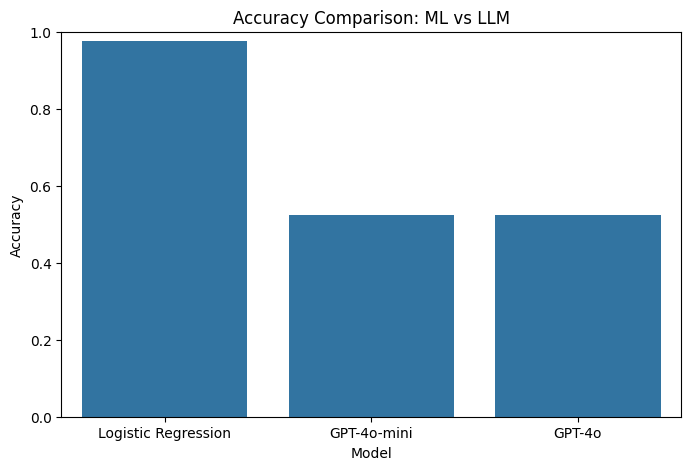

FileNotFoundError: [Errno 2] No such file or directory: 'results/accuracy_comparison.png'

<Figure size 640x480 with 0 Axes>

In [16]:
# Checks all variables before plotting

required_vars = ["ml_preds", "llm_preds_mini", "llm_preds_4o", "y_test", "sample_labels"]

missing = [v for v in required_vars if v not in globals()]
if missing:
    raise ValueError(f"Missing variables: {missing}. Run all ML + LLM cells first.")

results = {
    "Model": ["Logistic Regression", "GPT-4o-mini", "GPT-4o"],
    "Accuracy": [
        accuracy_score(y_test, ml_preds),
        accuracy_score(sample_labels, llm_preds_mini),
        accuracy_score(sample_labels, llm_preds_4o)
    ]
}

res_df = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
sns.barplot(data=res_df, x="Model", y="Accuracy")
plt.title("Accuracy Comparison: ML vs LLM")
plt.ylim(0, 1)
plt.show()
plt.savefig("results/accuracy_comparison.png", dpi=300, bbox_inches="tight")
plt.show()



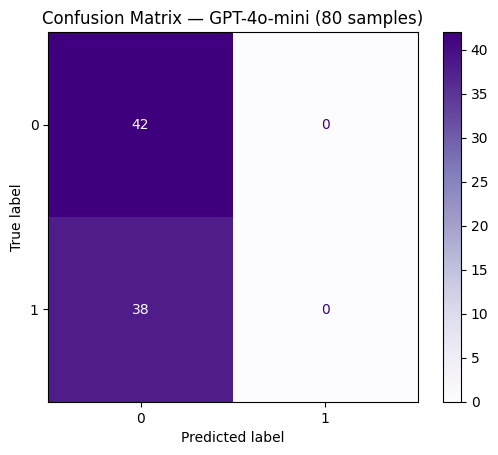

FileNotFoundError: [Errno 2] No such file or directory: 'results/confusion_matrix_gpt4o_mini.png'

<Figure size 640x480 with 0 Axes>

In [17]:
# CONFUSION MATRIX FOR GPT-4o-mini
cm = confusion_matrix(sample_labels, llm_preds_mini)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Purples")
plt.title("Confusion Matrix — GPT-4o-mini (80 samples)")
plt.show()
plt.savefig("results/confusion_matrix_gpt4o_mini.png", dpi=300, bbox_inches="tight")
plt.show()



In [18]:
import os
os.getcwd()


'/mnt/c/Users/steva/OneDrive/Programiranje/Neural Networks/Projects/fake-real-news-ml-vs-llm/notebooks'